In [1]:
# BATS (DG)s
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import gsw
import scipy.io as si
from scipy.optimize import fmin
from scipy.signal import savgol_filter
from netCDF4 import Dataset
import pickle
import datetime
import pickle
# functions I've written 
from glider_cross_section import Glider
from mode_decompositions import eta_fit, vertical_modes, PE_Tide_GM, vertical_modes_f
from toolkit import spectrum_fit, nanseg_interp, plot_pro, find_nearest

# matplotlib.rcParams['figure.figsize'] = (14,10)

# --- PHYSICAL PARAMETERS
g = 9.81
rho0 = 1025  # - 1027
ref_lat = 31.7
ref_lon = 64.2
f_ref = np.pi * np.sin(np.deg2rad(ref_lat)) / (12 * 1800)
# --- MODE PARAMETERS
# frequency zeroed for geostrophic modes
omega = 0
# highest baroclinic mode to be calculated
mmax = 45
nmodes = mmax + 1
# maximum allowed deep shear [m/s/km]
deep_shr_max = 0.1
# minimum depth for which shear is limited [m]
deep_shr_max_dep = 3500
eta_fit_depth_min = 250
eta_fit_depth_max = 3800  # 3900
# --- BIN PARAMETERS
GD = Dataset('BATs_2015_gridded_apr04.nc', 'r')
bin_depth = GD.variables['grid'][:]

# ----------------------------------------------------------------------------------------------------------------------
# ---- PROCESSING USING GLIDER PACKAGE
gs = 12
ge = 175
x = Glider(35, np.arange(gs, ge + 1), '/Users/jake/Documents/baroclinic_modes/DG/BATS_2015/sg035')

# Test alternate density computation
import_dg = si.loadmat('/Users/jake/Documents/baroclinic_modes/sg035_2015_neutral_density_bin.mat')
dg_data = import_dg['out']
limm = 450
profile_tags = dg_data['prof_number'][0][0][0]
if profile_tags[0] == gs:
    first = 0
else:
    first = np.where(profile_tags < gs)[0][-1] + 1
if profile_tags[-1] == ge + 0.5:
    last = len(profile_tags)
else:
    last = np.where(profile_tags > ge)[0][0] - 1
d_in = range(first, last)
profile_tags = profile_tags[d_in]
neutral_density = dg_data['Neut_den'][0][0][0:limm, d_in]
t = dg_data['Temp'][0][0][0:limm, d_in]
s = dg_data['Sal'][0][0][0:limm, d_in]
lon = dg_data['Lon'][0][0][0:limm, d_in]
lat = dg_data['Lat'][0][0][0:limm, d_in]
dac_u = dg_data['Dac_u'][0][0][0]
dac_v = dg_data['Dac_v'][0][0][0]
d_time = dg_data['Time'][0][0][0:limm, d_in] - 366
t_s = datetime.date.fromordinal(np.int(np.nanmin(d_time)))
t_e = datetime.date.fromordinal(np.int(np.nanmax(d_time)))
ref_lat = np.nanmean(lat)
time_rec_bin = np.nanmean(d_time, axis=0)
grid = dg_data['Depth'][0][0][0:limm, 0]
grid_p = gsw.p_from_z(-1 * grid, ref_lat)
grid_p[0] = 0
z = -1 * grid
sz_g = grid.shape[0]


In [2]:
# -- Compute density
sa, ct, theta, sig0, sig2, dg_N2 = x.density(grid, ref_lat, t, s, lon, lat)

In [3]:
# -- Background density profiles and seasonal variability
# Season Boundaries 
bd1 = 735750  # june1 (june1 = 735750) (may15 = 735733)
bd2 = 735856  # sept15

# split to account for horizontal gradients (should split for onshore/offshore of bermuda)
lon_lim = -64.09

# (June 1 - Sept 15)
d_summer_w = np.where(((time_rec_bin > bd1) & (time_rec_bin < bd2)) & (np.nanmean(lon, axis=0) < lon_lim))[0]
d_summer_e = np.where(((time_rec_bin > bd1) & (time_rec_bin < bd2)) & (np.nanmean(lon, axis=0) > lon_lim))[0]
# (Winter 1 = Feb 2 - June 1) - (Winter 2 = Sept 15 - Nov 5)
d_winter_w1 = np.where((time_rec_bin < bd1) & ((profile_tags < 60) | (profile_tags > 71))
                       & (np.nanmean(lon, axis=0) < lon_lim))[0]
d_winter_e1 = np.where((time_rec_bin < bd1) & ((profile_tags < 60) | (profile_tags > 71))
                       & (np.nanmean(lon, axis=0) > lon_lim))[0]
d_winter_w2 = np.where((time_rec_bin > bd2) & ((profile_tags < 60) | (profile_tags > 71))
                       & (np.nanmean(lon, axis=0) < lon_lim))[0]
d_winter_e2 = np.where((time_rec_bin > bd2) & ((profile_tags < 60) | (profile_tags > 71))
                       & (np.nanmean(lon, axis=0) > lon_lim))[0]

bckgrds = [d_summer_w, d_summer_e, d_winter_w1, d_winter_e1, d_winter_w2, d_winter_e2]
bckgrds_info = ['Summer West', 'Summer East','Winter1 West', 'Winter1 East','Winter2 West', 'Winter2 East']
# ABOVE SETS ORDER OF N2 PROFILES (different that order at the end)
# bckgrds_wins = np.array([bd1, bd2])  # summer boundaries
# bckgrds = [d_win1, d_sum, d_win2, d_eddy]  # KEY!! at the end, sets of profiles

salin_avg = np.nan * np.zeros((len(grid), len(bckgrds)))
cons_t_avg = np.nan * np.zeros((len(grid), len(bckgrds)))
theta_avg = np.nan * np.zeros((len(grid), len(bckgrds)))
sigma_theta_avg = np.nan * np.zeros((len(grid), len(bckgrds)))
ddz_avg_sigma = np.nan * np.zeros((len(grid), len(bckgrds)))
N2_0 = np.nan * np.zeros(sigma_theta_avg.shape)
N2_ref = np.nan * np.zeros(sigma_theta_avg.shape)
N = np.nan * np.zeros(sigma_theta_avg.shape)
for i in range(6):
    inn = bckgrds[i]
    salin_avg[:, i] = np.nanmean(sa[:, inn], axis=1)
    cons_t_avg[:, i] = np.nanmean(ct[:, inn], axis=1)
    theta_avg[:, i] = np.nanmean(theta[:, inn], axis=1)
    sigma_theta_avg[:, i] = np.nanmean(neutral_density[:, inn], axis=1)
    ddz_avg_sigma[:, i] = np.gradient(sigma_theta_avg[:, i], z)
    go = ~np.isnan(salin_avg[:, i])
    N2_0[np.where(go)[0][0:-1], i] = gsw.Nsquared(salin_avg[go, i], cons_t_avg[go, i], grid_p[go], lat=ref_lat)[0]
    N2_0[N2_0[:, i] < 0] = np.nan  # 1 * 10**-7
    N2_ref[:, i] = nanseg_interp(grid, N2_0[:, i])
    # N2_ref[:, i] = savgol_filter(N2_ref[:, i], 5, 3)
N2_ref[-1, :] = N2_ref[-2, :] - 1 * 10**-9
N2 = N2_ref.copy()

N2_all = np.nan * np.zeros(len(grid))
N2_all[0:-1] = gsw.Nsquared(np.nanmean(salin_avg, axis=1), np.nanmean(cons_t_avg, axis=1), grid_p, lat=ref_lat)[0]
N2_all[-2:] = N2_all[-3]
N2_all[N2_all < 0] = np.nan
N2_all = nanseg_interp(grid, N2_all)
N_all = np.sqrt(N2_all)
N2_all = savgol_filter(N2_all, 5, 3)
N2_all[N2_all < 0] = np.nan
N2_all = nanseg_interp(grid, N2_all)

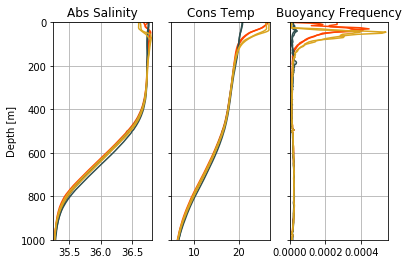

In [8]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
coli = 'r', 'm', 'b', 'c', 'g', 'y'  # summer, summer, winter1, winter1, winter2, winter2
coli = '#FF4500', '#FF4500', '#2F4F4F', '#2F4F4F', '#DAA520', '#DAA520'
# cols = ['#2F4F4F', '#FF4500', '#DAA520']
# season_labs = ['Feb-Apr', 'May-Sept', 'Sept-Nov']
for i in range(6):
    ax1.plot(salin_avg[:, i], grid, color=coli[i])
    ax2.plot(cons_t_avg[:, i], grid, color=coli[i])
    ax3.plot(N2_ref[:, i], grid, color=coli[i])
ax1.set_ylim([0, 1000])
ax1.grid()
ax2.grid()
ax1.invert_yaxis()
ax1.set_xlim([35.25, 36.81])
ax1.set_ylabel('Depth [m]')
ax1.set_title('Abs Salinity')
ax2.set_xlim([5, 27])
ax2.set_title('Cons Temp')
ax3.set_xlim([0, 0.00055])
ax3.set_title('Buoyancy Frequency')
plot_pro(ax3)
# ax3.grid()
# f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_3_27_19/bats_dg_t_s_n2.jpg", dpi=300)

In [17]:
# -- compute M/W sections and compute velocity
# -- USING X.TRANSECT_CROSS_SECTION_1 (THIS WILL SEPARATE TRANSECTS BY TARGET OF EACH DIVE)
sigth_levels = np.concatenate(
    [np.arange(23, 26.5, 0.5), np.arange(26.2, 27.2, 0.2),
     np.arange(27.2, 27.7, 0.2), np.arange(27.7, 28, 0.02), np.arange(28, 28.15, 0.01)])
# sigth_levels = np.concatenate([np.aranger(32, 36.6, 0.2), np.arange(36.6, 36.8, 0.05), np.arange(36.8, 37.4, 0.02)])

# --- SAVE so that we dont have to run transects every time
savee = 0
if savee > 0:
    ds, dist, avg_ct_per_dep_0, avg_sa_per_dep_0, avg_sig0_per_dep_0, v_g, vbt, isopycdep, isopycx, mwe_lon, mwe_lat,\
    DACe_MW, DACn_MW, profile_tags_per, shear, v_g_east, v_g_north = x.transect_cross_section_1(grid, neutral_density,
                                                                                                ct, sa, lon, lat,
                                                                                                dac_u, dac_v,
                                                                                                profile_tags,
                                                                                                sigth_levels)
    my_dict = {'ds': ds, 'dist': dist, 'avg_ct_per_dep_0': avg_ct_per_dep_0,
               'avg_sa_per_dep_0': avg_sa_per_dep_0, 'avg_sig0_per_dep_0': avg_sig0_per_dep_0, 'v_g': v_g, 'vbt': vbt,
               'isopycdep': isopycdep, 'isopycx': isopycx, 'mwe_lon': mwe_lon, 'mwe_lat': mwe_lat, 'DACe_MW': DACe_MW,
               'DACn_MW': DACn_MW, 'profile_tags_per': profile_tags_per, 'v_g_east': v_g_east, 'v_g_north': v_g_north}
    output = open('/Users/jake/Documents/baroclinic_modes/DG/sg035_2015_transects_test_3.pkl', 'wb')
    pickle.dump(my_dict, output)
    output.close()
else:
    pkl_file = open('/Users/jake/Documents/baroclinic_modes/DG/sg035_2015_transects_test_3.pkl', 'rb')
    B15 = pickle.load(pkl_file)
    pkl_file.close()
    ds = B15['ds']
    dist = B15['dist']
    avg_ct_per_dep_0 = B15['avg_ct_per_dep_0']
    avg_sa_per_dep_0 = B15['avg_sa_per_dep_0']
    avg_sig0_per_dep_0 = B15['avg_sig0_per_dep_0']
    v_g = B15['v_g']
    v_g_east = B15['v_g_east']
    v_g_north = B15['v_g_north']
    vbt = B15['vbt']
    isopycdep = B15['isopycdep']
    isopycx = B15['isopycx']
    mwe_lon = B15['mwe_lon']
    mwe_lat = B15['mwe_lat']
    DACe_MW = B15['DACe_MW']
    DACn_MW = B15['DACn_MW']
    profile_tags_per = B15['profile_tags_per']

# unpack velocity profiles from transect analysis
dace_mw_0 = DACe_MW[0][0:-1].copy()
dacn_mw_0 = DACn_MW[0][0:-1].copy()
dg_v_0 = v_g[0][:, 0:-1].copy()
dg_v_e_0 = v_g_east[0][:, 0:-1].copy()
dg_v_n_0 = v_g_north[0][:, 0:-1].copy()
avg_sig0_per_dep = avg_sig0_per_dep_0[0].copy()
avg_ct_per_dep = avg_ct_per_dep_0[0].copy()
avg_sa_per_dep = avg_sa_per_dep_0[0].copy()
dg_v_lon = mwe_lon[0][0:-1].copy()
dg_v_lat = mwe_lat[0][0:-1].copy()
dg_v_dive_no_0 = profile_tags_per[0][0:-1].copy()
for i in range(1, len(v_g)):
    dace_mw_0 = np.concatenate((dace_mw_0, DACe_MW[i][0:-1]), axis=0)
    dacn_mw_0 = np.concatenate((dacn_mw_0, DACn_MW[i][0:-1]), axis=0)
    dg_v_0 = np.concatenate((dg_v_0, v_g[i][:, 0:-1]), axis=1)
    dg_v_e_0 = np.concatenate((dg_v_e_0, v_g_east[i][:, 0:-1]), axis=1)
    dg_v_n_0 = np.concatenate((dg_v_n_0, v_g_north[i][:, 0:-1]), axis=1)
    avg_ct_per_dep = np.concatenate((avg_ct_per_dep, avg_ct_per_dep_0[i]), axis=1)
    avg_sa_per_dep = np.concatenate((avg_sa_per_dep, avg_sa_per_dep_0[i]), axis=1)
    avg_sig0_per_dep = np.concatenate((avg_sig0_per_dep, avg_sig0_per_dep_0[i]), axis=1)
    dg_v_lon = np.concatenate((dg_v_lon, mwe_lon[i][0:-1]))
    dg_v_lat = np.concatenate((dg_v_lat, mwe_lat[i][0:-1]))
    dg_v_dive_no_0 = np.concatenate((dg_v_dive_no_0, profile_tags_per[i][0:-1]))

# Time matching to eta/v profiles
count = 0
for i in range(0, len(profile_tags_per)):
    these_dives = profile_tags_per[i]
    for j in range(len(these_dives) - 1):
        tin = time_rec_bin[np.in1d(profile_tags, these_dives[j:j+2])]
        if count < 1:
            dg_mw_time_0 = np.array([np.nanmean(tin)])
        else:
            dg_mw_time_0 = np.concatenate((dg_mw_time_0, np.array([np.nanmean(tin)])))
        count = count + 1
        
prof_lon_i = np.nanmean(lon, axis=0)
prof_lat_i = np.nanmean(lat, axis=0)        

In [18]:
avg_sa_per_dep_0[0][100, :]

array([         nan,  36.50260644,  36.48208069,  36.47614051,          nan])

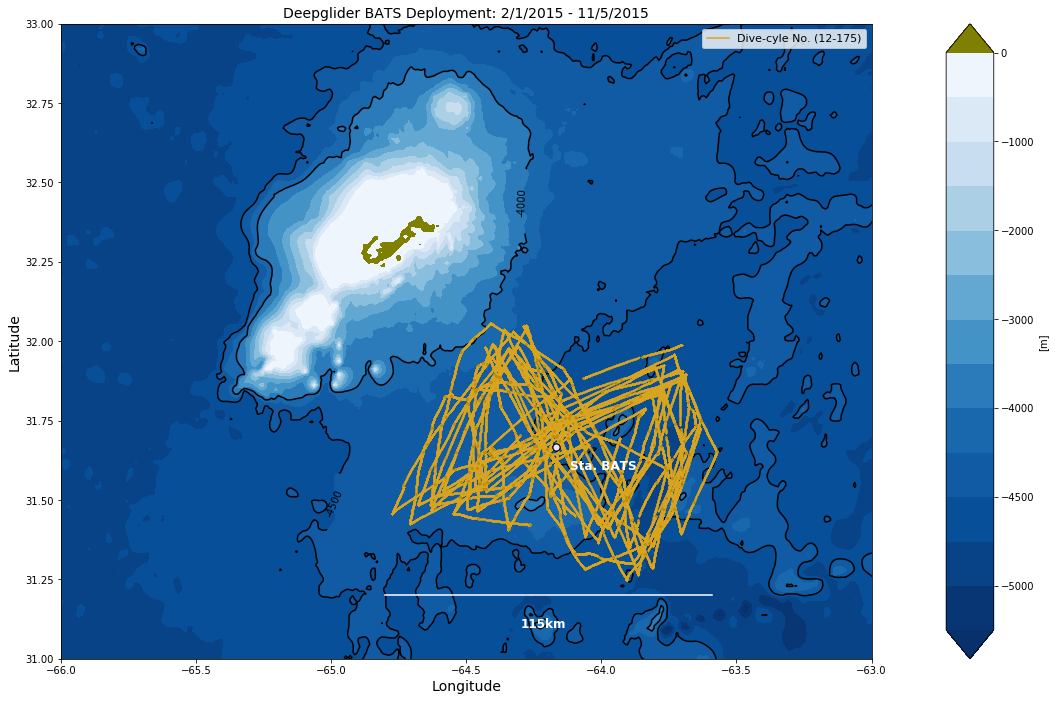

In [72]:
# PLAN VIEW PLOt
from mpl_toolkits.axes_grid1 import make_axes_locatable

bath = '/Users/jake/Desktop/bats/bats_bathymetry/GEBCO_2014_2D_-67.7_29.8_-59.9_34.8.nc'
bath_fid = Dataset(bath, 'r')
bath_lon = bath_fid.variables['lon'][:]
bath_lat = bath_fid.variables['lat'][:]
bath_z = bath_fid.variables['elevation'][:]
levels = [-5250, -5000, -4750, -4500, -4250, -4000, -3500, -3000, -2500, -2000, -1500, -1000, -500, 0]
fig0, ax0 = plt.subplots()
cmap = plt.cm.get_cmap("Blues_r")
cmap.set_over('#808000')  # ('#E6E6E6')
bc = ax0.contourf(bath_lon, bath_lat, bath_z, levels, cmap='Blues_r', extend='both', zorder=0)
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'
bcl = ax0.contour(bath_lon, bath_lat, bath_z, [-4500, -4000], colors='k', zorder=0)
ml = [(-65, 31.5), (-64.4, 32.435)]
ax0.clabel(bcl, manual=ml, inline_spacing=-3, fmt='%1.0f', colors='k')
ax0.scatter(lon, lat, s=0.3, color='#DAA520')
ax0.scatter(dg_v_lon, dg_v_lat, s=3, color='#DAA520', edgecolor='#B8860B')
ax0.plot(lon[:, -1], lat[:, -1], color='#DAA520',
        label='Dive-cyle No. (' + str(int(profile_tags[0])) + '-' + str(int(profile_tags[-2])) + ')', zorder=1)
ax0.plot([-64.8, -63.59], [31.2, 31.2], color='w', zorder=2)
ax0.text(-64.3, 31.1, '115km', color='w', fontsize=12, fontweight='bold')
ax0.scatter(-(64 + (10 / 60)), 31 + (40 / 60), s=50, color='#E6E6FA', edgecolors='k', zorder=3)
ax0.scatter(-(64 + (10 / 60)), 31 + (40 / 60), s=50, color='#E6E6FA', edgecolors='k', zorder=4)
ax0.text(-(64 + (10 / 60)) + .05, 31 + (40 / 60) - .07, 'Sta. BATS', color='w', fontsize=12, fontweight='bold')
w = 1 / np.cos(np.deg2rad(ref_lat))
ax0.axis([-66, -63, 31, 33])
ax0.set_aspect(w)
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig0.colorbar(bc, cax=cax, label='[m]')
ax0.set_xlabel('Longitude', fontsize=14)
ax0.set_ylabel('Latitude', fontsize=14)
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles, labels, fontsize=11)
ax0.set_title('Deepglider BATS Deployment: ' + np.str(t_s.month) + '/' + np.str(t_s.day) + '/' + np.str(
    t_s.year) + ' - ' + np.str(t_e.month) + '/' + np.str(t_e.day) + '/' + np.str(t_e.year), fontsize=14)
plt.tight_layout()

(937,)
(601,)
(601, 937)
31.6291666667
[ -1.22852214e-03  -4.41903522e+03]


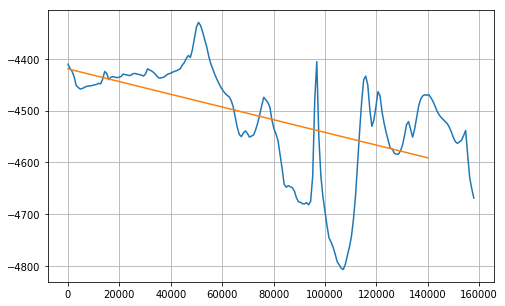

()

In [121]:
print(np.shape(bath_lon))
print(np.shape(bath_lat))
print(np.shape(bath_z))
lat_sel = 220
print(bath_lat[lat_sel])

lon_sel = bath_lon[340:540]
z_sel = bath_z[lat_sel, 340:540]
x_sel = 1852 * 60 * np.cos(np.deg2rad(31.00)) * (lon_sel - lon_sel[0])

print(np.polyfit(x_sel, z_sel, 1))
fitt = np.polyval(np.polyfit(x_sel, z_sel, 1), np.arange(0, 150000, 10000))

matplotlib.rcParams['figure.figsize'] = (8,5)
f, ax  = plt.subplots()
ax.plot(x_sel, z_sel)
ax.plot(np.arange(0, 150000, 10000), fitt)
plot_pro(ax)

In [19]:
# Eta from M/W method, which produces an average density per set of profiles
eta_alt = np.nan * np.ones(np.shape(avg_sig0_per_dep))
eta_alt_2 = np.nan * np.ones(np.shape(avg_sig0_per_dep))
eta_alt_3 = np.nan * np.ones(np.shape(avg_sig0_per_dep))
d_anom_alt = np.nan * np.ones(np.shape(avg_sig0_per_dep))
gradient_alt = np.nan * np.ones(np.shape(avg_sig0_per_dep))
for i in range(np.shape(avg_sig0_per_dep)[1]):  # loop over each profile
    # (average of four profiles) - (total long term average, that is seasonal)
    this_time = dg_mw_time_0[i]
    this_lon = dg_v_lon[i]
    # match profile with appropriate background (in time and space)
    # t_over = np.where(bckgrds_wins > this_time)[0]
    # bckgrds_wins = np.array([735750, 735857])  # summer boundaries

    # first sort by lon
    # [d_summer_w, d_summer_e, d_winter_w1, d_winter_e1, d_winter_w2, d_winter_e2]
    if this_lon < lon_lim:
        if (this_time > bd1) & (this_time < bd2):  # summer
            t_over = 0  # summer west
        elif this_time < bd1:
            t_over = 2  # winter west 1
        else:
            t_over = 4  # winter west 2
    else:
        if (this_time > bd1) & (this_time < bd2):  # summer
            t_over = 1  # summer east
        elif this_time < bd1:
            t_over = 3  # winter east 1
        else:
            t_over = 5  # winter west 2

    # ETA ALT (avg_sig0_per_dep and sigma_theta_avg are really neutral density, imported from matlab binning)
    # match profile (really avg of 3/4 profiles) with one of 4 seasonal background profiles
    this_sigma_theta_avg = sigma_theta_avg[:, t_over]
    eta_alt[:, i] = (avg_sig0_per_dep[:, i] - sigma_theta_avg[:, t_over]) / np.squeeze(ddz_avg_sigma[:, t_over])
    d_anom_alt[:, i] = (avg_sig0_per_dep[:, i] - sigma_theta_avg[:, t_over])        
            
    # ETA ALT 2
    # find appropriate average background profiles
    avg_a_salin = salin_avg[:, t_over]
    avg_c_temp = cons_t_avg[:, t_over]

    # compute density at every depth for every profile using sa and ct profiles (really avg of 3/4 profiles)
    # eta_alt_2 is compute using a local reference pressure
    # loop over each bin depth
    for j in range(2, len(grid) - 2):
        if ~np.isnan(avg_sa_per_dep[j, i]):
            # profile density at depth j with local reference pressure (call p2)
            this_sigma = gsw.rho(avg_sa_per_dep[j, i], avg_ct_per_dep[j, i], grid_p[j]) - 1000      # profile density
            # background density at points above and below p2 with local reference pressure (p2)
            this_sigma_avg = gsw.rho(avg_a_salin[j-2:j+3], avg_c_temp[j-2:j+3], grid_p[j]) - 1000
            d_anom_alt[j, i] = this_sigma - this_sigma_avg[1]
            gradient_alt[j, i] = np.nanmean(np.gradient(this_sigma_avg, z[j-2:j+3]))
            # gradient_alt[j, i] = (this_sigma_avg[0] - this_sigma_avg[2]) / (grid[j-1] - grid[j+1])
            eta_alt_2[j, i] = d_anom_alt[j, i] / gradient_alt[j, i]

    # ETA ALT 3
    # try a new way to compute vertical displacement
    for j in range(len(grid)):
        # find this profile density at j along avg profile
        idx, rho_idx = find_nearest(this_sigma_theta_avg, avg_sig0_per_dep[j, i])
        if idx <= 2:
            z_rho_1 = grid[0:idx + 3]
            eta_alt_3[j, i] = np.interp(avg_sig0_per_dep[j, i], this_sigma_theta_avg[0:idx + 3], z_rho_1) - grid[j]
        else:
            z_rho_1 = grid[idx - 2:idx + 3]
            eta_alt_3[j, i] = np.interp(avg_sig0_per_dep[j, i], this_sigma_theta_avg[idx - 2:idx + 3], z_rho_1) - grid[j]

# eta_alt = gamma / ddz 
# eta_alt_2 = local potential density / local ddz 
# eta_alt_3 = direct search for gamma on background profile (difference in depths then computed)
eta_alt_0 = eta_alt.copy()

In [15]:
# --- ETA COMPUTED FROM INDIVIDUAL DENSITY PROFILES (AND PE from function)
G_all, Gz_all, c_all, epsilon_all = vertical_modes(N2_all, grid, omega, mmax)
eta_per_prof = np.nan * np.ones(sig2.shape)
eta_per_prof_3 = np.nan * np.ones(sig2.shape)
d_anom_prof = np.nan * np.ones(sig2.shape)
for i in range(lon.shape[1]):
    this_lon = np.nanmean(lon[:, i])
    this_time = np.nanmean(d_time[:, i])
    # t_over = np.where(bckgrds_wins > this_time)[0]

    # [d_summer_w, d_summer_e, d_winter_w1, d_winter_e1, d_winter_w2, d_winter_e2]
    if this_lon < lon_lim:
        if (this_time > bd1) & (this_time < bd2):  # summer
            t_over = 0  # summer west
        elif this_time < bd1:
            t_over = 2  # winter west 1
        else:
            t_over = 4  # winter west 2
    else:
        if (this_time > bd1) & (this_time < bd2):  # summer
            t_over = 1  # summer east
        elif this_time < bd1:
            t_over = 3  # winter east 1
        else:
            t_over = 5  # winter west 2

    this_sigma_theta_avg = sigma_theta_avg[:, t_over]
    eta_per_prof[:, i] = (neutral_density[:, i] - sigma_theta_avg[:, t_over]) / np.squeeze(ddz_avg_sigma[:, t_over])
    d_anom_prof[:, i] = (neutral_density[:, i] - sigma_theta_avg[:, t_over])

    # ETA ALT 3
    # try a new way to compute vertical displacement
    for j in range(len(grid)):
        # find this profile density at j along avg profile
        idx, rho_idx = find_nearest(this_sigma_theta_avg, neutral_density[j, i])
        if idx <= 2:
            z_rho_1 = grid[0:idx + 3]
            eta_per_prof_3[j, i] = np.interp(neutral_density[j, i], this_sigma_theta_avg[0:idx + 3],
                                             z_rho_1) - grid[j]
        else:
            z_rho_1 = grid[idx - 2:idx + 3]
            eta_per_prof_3[j, i] = np.interp(neutral_density[j, i], this_sigma_theta_avg[idx - 2:idx + 3],
                                             z_rho_1) - grid[j]

AG_all, eta_m_all, Neta_m_all, PE_per_mass_all = eta_fit(lon.shape[1], grid, nmodes, N2_all, G_all, c_all,
                                                         eta_per_prof_3, eta_fit_depth_min, eta_fit_depth_max)
PE_per_mass_all = PE_per_mass_all[:, np.abs(AG_all[1, :]) > 1*10**-4]

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:253: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/jake/Documents/geostrophic_turbulence/mode_decompositions.py:248: RuntimeWarning: overflow encountered in ushort_scalars
  eta_fs[i_dp[0]] = (grid[i_dp] - grid[-1]) * this_eta[iw[0][-1]] / (grid[iw[0][-1]] - grid[-1])
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in greater


In [20]:
# FILTER VELOCITY PROFILES IF THEY ARE TOO NOISY / BAD -- ALSO HAVE TO REMOVE EQUIVALENT ETA PROFILE (non-ind profiles)
# select only velocity profiles that seem reasonable
# criteria are slope of v (dont want kinks)
# criteria: limit surface velocity to greater that 40cm/s
good_v = np.zeros(np.shape(dg_v_0)[1], dtype=bool)
for i in range(np.shape(dg_v_0)[1]):
    dv_dz = np.gradient(dg_v_0[:, i], -1 * grid)
    if np.nanmax(np.abs(dv_dz)) < 0.02:  # 0.0225
        good_v[i] = True

avg_sig = avg_sig0_per_dep[:, good_v]
eta_alt = eta_alt_3[:, good_v]
dace_mw = dace_mw_0[good_v]
dacn_mw = dacn_mw_0[good_v]
dg_v = dg_v_0[:, good_v]
dg_v_e = dg_v_e_0[:, good_v]
dg_v_n = dg_v_n_0[:, good_v]
dg_mw_time = dg_mw_time_0[good_v]
dg_v_dive_no = dg_v_dive_no_0[good_v]
num_mw_profs = np.shape(eta_alt)[1]

# Smooth DG N2 profiles
dg_avg_N2_coarse = np.nanmean(dg_N2, axis=1)
dg_avg_N2_coarse[np.isnan(dg_avg_N2_coarse)] = dg_avg_N2_coarse[~np.isnan(dg_avg_N2_coarse)][0] - 1*10**(-5)
dg_avg_N2 = savgol_filter(dg_avg_N2_coarse, 15, 3)

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: All-NaN slice encountered
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:23: RuntimeWarning: Mean of empty slice


In [21]:
# dives to choose from in comparing etas below 
dg_v_dive_no

array([  12.5,   13. ,   13.5,   27.5,   28. ,   28.5,   40.5,   48.5,
         49. ,   49.5,   59.5,   60. ,   60.5,   72.5,   73. ,   73.5,
         88.5,   97.5,  109.5,  110. ,  110.5,  119.5,  128.5,  139.5,
        140. ,  140.5,  151.5,  152. ,  152.5,  160.5,  161. ,  161.5,
        173.5,   20.5,   32.5,   33. ,   33.5,   44.5,   54.5,   55. ,
         55.5,   65.5,   66. ,   66.5,   79.5,   80. ,   80.5,   81. ,
         81.5,   82. ,   82.5,   83. ,   83.5,   84. ,   84.5,   92.5,
         93. ,   93.5,  102. ,  102.5,  114.5,  115. ,  115.5,  123.5,
        124. ,  124.5,  132.5,  133. ,  133.5,  134. ,  134.5,  156.5,
        166.5,  167. ,  167.5,   38.5,  145.5,   17.5,   18. ,   18.5,
         30.5,   42.5,   51.5,   52. ,   52.5,   62.5,   63. ,   63.5,
         75.5,   76. ,   76.5,   77. ,   77.5,   90.5,   99.5,  121.5,
        130.5,  142.5,  154.5,  163.5,  164. ,  164.5,   22.5,   23. ,
         23.5,   24. ,   24.5,   25. ,   25.5,   35.5,   36. ,   36.5,
      

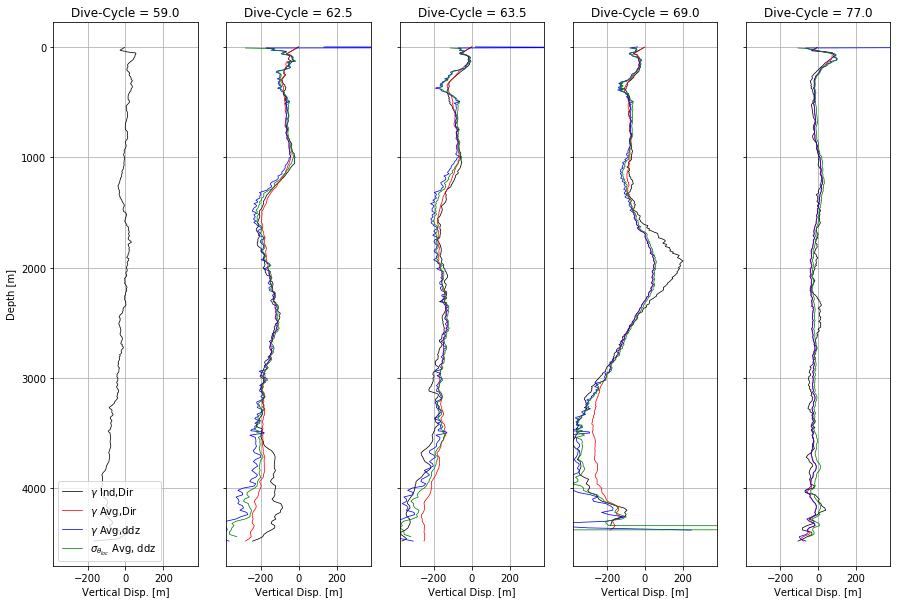

In [44]:
# plot etas calculated above
# these_profiles = np.array([27.5,   28. ,   28.5,   40.5,   48.5])
# these_profiles = np.array([52, 53, 54, 55, 56])
# these_profiles = np.array([75.5, 76, 76.5, 77, 77.5])
# these_profiles = np.array([ 81.5,   82. ,   82.5,   83. ,   83.5])
# these_profiles = np.array([132.5,  133. ,  133.5,  134. ,  134.5,])
# these_profiles = np.array([50, 75, 100, 125])  # dive numbers of profiles to compare (individual dives)
# these_profiles = np.array([60, 85, 110, 135])  # dive numbers of profiles to compare (individual dives)
these_profiles = np.array([59, 62.5, 63.5, 69, 77])  # dive numbers of profiles to compare (individual dives)
# these_profiles = np.array([67, 68, 69, 70, 71])  # dive numbers of profiles to compare (individual dives)
# these_profiles = np.array([72, 72.5, 73, 73.5, 74])  # dive numbers of profiles to compare (individual dives)

plt.rcParams['figure.figsize'] = 15, 10
f, ax = plt.subplots(1, 5, sharey=True)
for i in range(5):
    ind_rel = profile_tags == these_profiles[i]
    avg_rel = dg_v_dive_no_0 == these_profiles[i]
    ax[i].plot(eta_per_prof_3[:, ind_rel], grid, color='k', linewidth=0.75, label=r'$\gamma$ Ind,Dir')  # individual profiles direct search, gamma
    ax[i].plot(eta_alt_3[:, avg_rel], grid, color='r', linewidth=0.75, label=r'$\gamma$ Avg,Dir')  # avg direct search, gamma
    ax[i].plot(-1 * eta_alt_0[:, avg_rel], grid, color='b', linewidth=0.75, label=r'$\gamma$ Avg,ddz')  # avg divide by ddz, gamma
    ax[i].plot(-1 * eta_alt_2[:, avg_rel], grid, color='g', linewidth=0.75, label=r'$\sigma_{\theta_{loc}}$ Avg, ddz')  # avg divide by ddz, pot den, local pref
    ax[i].set_xlim([-380, 380])
    ax[i].set_title('Dive-Cycle = ' + str(these_profiles[i]))
    ax[i].set_xlabel('Vertical Disp. [m]', fontsize=10)

handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles, labels, fontsize=10)
ax[0].set_ylabel('Depth [m]')
ax[4].invert_yaxis()
ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[3].grid()
plot_pro(ax[4])
# ax[4].grid()
# f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_3_27_19/eddy_etas.jpg", dpi=300)

In [45]:
# --- VERTICAL MODES ---
# --- compute vertical mode shapes
# by season
# [d_summer_w, d_summer_e, d_winter_w1, d_winter_e1, d_winter_w2, d_winter_e2] ordering set above
# N2 order = 
G_0, Gz_0, c_0, epsilon_0 = vertical_modes(np.nanmean(N2[:, 2:4], axis=1), grid, omega, mmax)  # winter1
G_1, Gz_1, c_1, epsilon_1 = vertical_modes(np.nanmean(N2[:, 0:2], axis=1), grid, omega, mmax)  # summer
G_2, Gz_2, c_2, epsilon_2 = vertical_modes(np.nanmean(N2[:, 4:], axis=1), grid, omega, mmax)  # winter2
Gs = [G_0, G_1, G_2]
Gzs = [Gz_0, Gz_1, Gz_2]
cs = [c_0, c_1, c_2]
epsilons = [epsilon_0, epsilon_1, epsilon_2]
# test using average over entire year
G_tot, Gz_tot, c_tot, epsilon_tot = vertical_modes(np.nanmean(N2, axis=1), grid, omega, mmax)  # N2

# --- compute alternate vertical modes
bc_bot = 2  # 1 = flat, 2 = rough
grid2 = np.concatenate([np.arange(0, 150, 10), np.arange(150, 300, 10), np.arange(300, 4500, 10)])
n2_interp = np.interp(grid2, grid, dg_avg_N2)
n2_interp[0] = n2_interp[1] - 0.000001
F_int_g2, F_g2, c_ff, norm_constant, epsilon2 = vertical_modes_f(n2_interp, grid2, omega, mmax, bc_bot)
F = np.nan * np.ones((np.size(grid), mmax + 1))
F_int = np.nan * np.ones((np.size(grid), mmax + 1))
for i in range(mmax + 1):
    F[:, i] = np.interp(grid, grid2, F_g2[:, i])
    F_int[:, i] = np.interp(grid, grid2, F_int_g2[:, i])

# --- test season differences in modes
cols = ['#2F4F4F', '#FF4500', '#DAA520', '#800080']
season_labs = ['Feb-Apr', 'May-Sept', 'Sept-Nov']

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:253: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


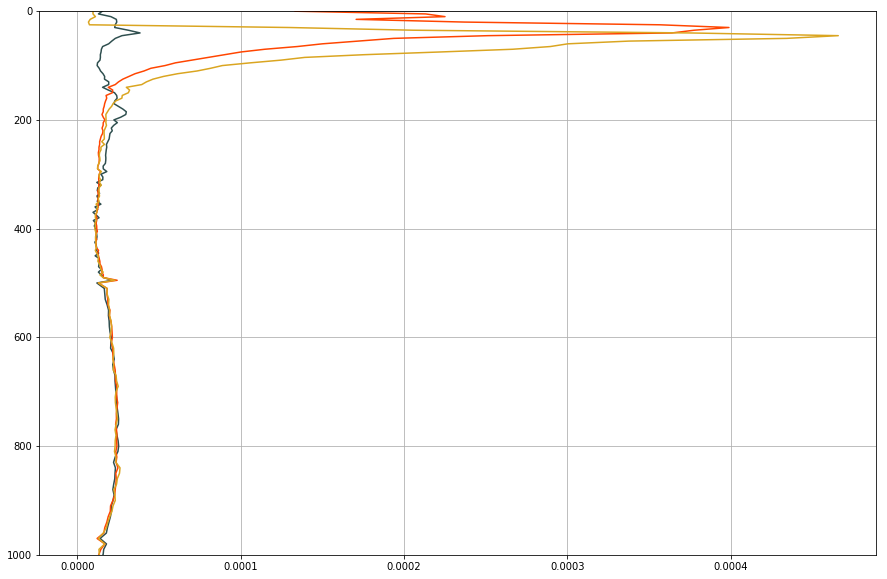

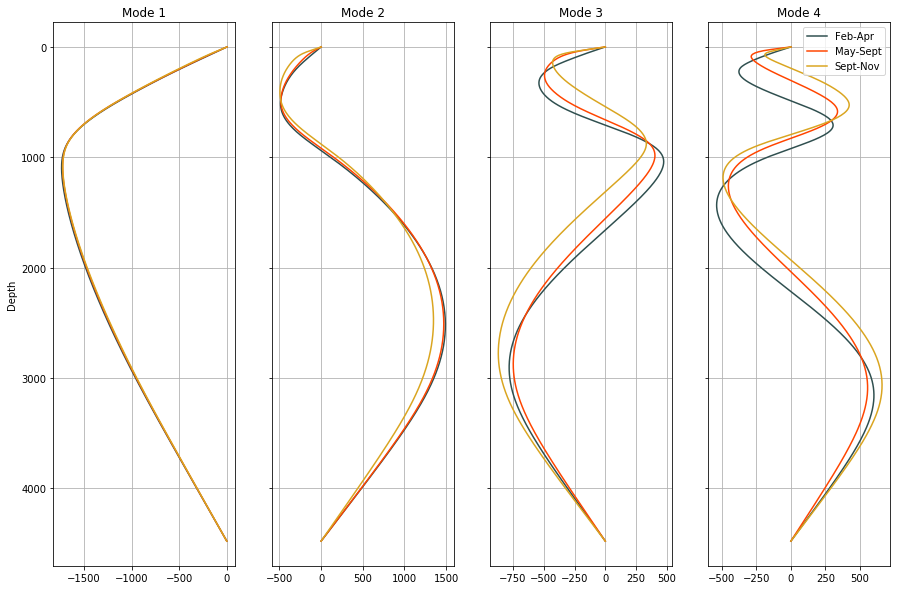

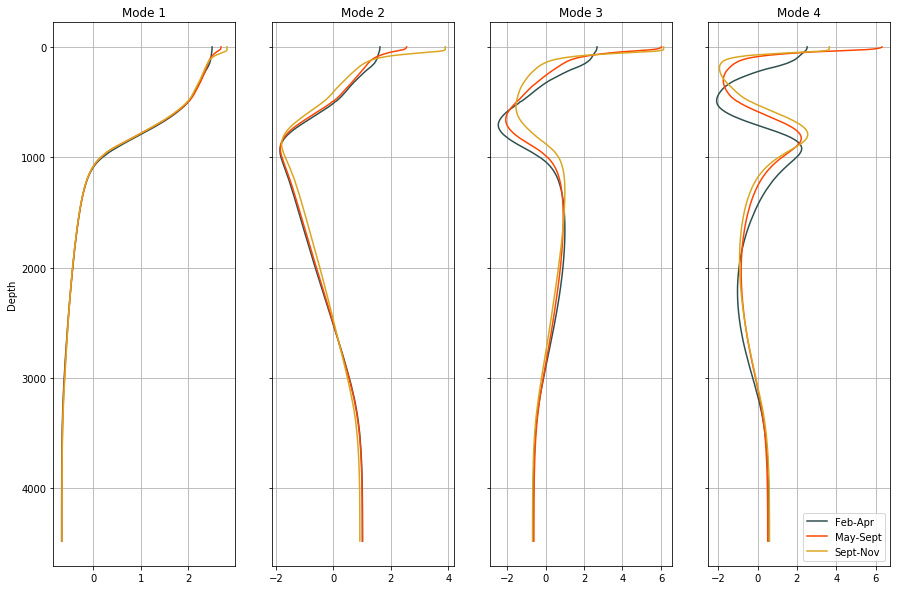

()

In [46]:
# PLOT --- test season differences in modes
f, ax = plt.subplots()
ax.plot(np.nanmean(N2[:, 2:4], axis=1), grid, color=cols[0])
ax.plot(np.nanmean(N2[:, 0:2], axis=1), grid, color=cols[1])
ax.plot(np.nanmean(N2[:, 4:], axis=1), grid, color=cols[2])
ax.set_ylim([0, 1000])
ax.invert_yaxis()
plot_pro(ax)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
for i in range(len(Gs)):
    ax1.plot(Gs[i][:, 1], grid, color=cols[i])
    ax2.plot(Gs[i][:, 2], grid, color=cols[i])
    ax3.plot(Gs[i][:, 3], grid, color=cols[i])
    ax4.plot(Gs[i][:, 4], grid, color=cols[i], label=season_labs[i])
ax1.set_title('Mode 1')
ax1.set_ylabel('Depth')
ax1.grid()
ax2.set_title('Mode 2')
ax2.grid()
ax3.set_title('Mode 3')
ax3.grid()
ax4.set_title('Mode 4')
ax4.invert_yaxis()
handles, labels = ax4.get_legend_handles_labels()
ax4.legend(handles, labels, fontsize=10)
plot_pro(ax4)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
for i in range(len(Gs)):
    ax1.plot(Gzs[i][:, 1], grid, color=cols[i])
    ax2.plot(Gzs[i][:, 2], grid, color=cols[i])
    ax3.plot(Gzs[i][:, 3], grid, color=cols[i])
    ax4.plot(Gzs[i][:, 4], grid, color=cols[i], label=season_labs[i])
ax1.set_title('Mode 1')
ax1.set_ylabel('Depth')
ax1.grid()
ax2.set_title('Mode 2')
ax2.grid()
ax3.set_title('Mode 3')
ax3.grid()
ax4.set_title('Mode 4')
ax4.invert_yaxis()
handles, labels = ax4.get_legend_handles_labels()
ax4.legend(handles, labels, fontsize=10)
plot_pro(ax4)

From Zhao et al. 2016 (appendix A), the ratio of surface displacement to maximum interior displacement. He gave me a map at BATS of the surface displacement from the M2 and S2 internal tides (order 1 - 5mm). For every 1mm surface displacement we expect 750mm maximum interior displacement (for mode 1). If I estimate the interior displacement using his estimate of surface amplitude and my mode shapes (where there is a free surface, skewing his estimate) I get an interior displacement of less than 10 m for both the M2 and S2 tides.

In [11]:
# testing of tides from Dr. Zhao
normalizer = (1/np.nanmax(grid))*np.trapz(Gzs[0][:, 1]**2, grid)
(0.005) / ((1/g) * np.trapz(Gzs[0][:, 1] * np.nanmean(N2[:, 2:4], axis=1), grid))

1.5983952540299899

In [22]:
# Kjellsson and Zanna paper 2017 on the importance of resolving the deformation radius in modes 
Lr1 = (1/3.14159) * np.trapz(np.sqrt(N2[:, 0])/f_ref, grid)
print(Lr1/1000)
print((cs[0][1:4]/f_ref)/1000)


37.1479414496
[ 39.33132111  16.41174672  11.82046183]


In [37]:
# from the zanna paper Lr = radius of deformation (in figure 5, plot wavenumber )
1. / ((1.7 * 10**(-4))/(2*3.14))

36941.17647058823

In [47]:
# ----- SOME VELOCITY PROFILES ARE TOO NOISY AND DEEMED UNTRUSTWORTHY -------------------------------------------------
# really just copying at this point 
Avg_sig = avg_sig.copy()
Time2 = dg_mw_time.copy()
V2 = dg_v.copy()
Eta2 = eta_alt.copy()   # eta_alt already defined above as one of the three methods
Eta2_c = eta_alt.copy()
Info2 = dg_v_dive_no.copy()
prof_lon2 = dg_v_lon.copy()
prof_lat2 = dg_v_lat.copy()
# for this selection find appropriate background structure
# these are the indices that satisfy the different seasons
d2_summer = np.where((Time2 > bd1) & (Time2 < bd2))[0]
d2_winter1 = np.where((Time2 < bd1) & ((Info2 < 60) | (Info2 > 71)))[0]
d2_winter2 = np.where(Time2 > bd2)[0]
bckgrds2 = [d2_summer, d2_winter1, d2_winter2]

In [56]:
np.shape(dg_v_0)

(450, 261)

In [48]:
# ---- PROJECT MODES ONTO EACH PROFILE -------
# ---- Velocity and Eta (ENERGY)
sz = np.shape(Eta2)
num_profs = sz[1]
AG = np.zeros([nmodes, num_profs])
AGz = np.zeros([nmodes, num_profs])
Eta_m = np.nan * np.zeros([np.size(grid), num_profs])
V_m = np.nan * np.zeros([np.size(grid), num_profs])
Neta = np.nan * np.zeros([np.size(grid), num_profs])
NEta_m = np.nan * np.zeros([np.size(grid), num_profs])
PE_per_mass = np.nan * np.zeros([nmodes, num_profs])
HKE_per_mass = np.nan * np.zeros([nmodes, num_profs])
modest = np.arange(11, nmodes)
good_ke_prof = np.ones(num_profs)
good_pe_prof = np.ones(num_profs)
HKE_noise_threshold = 1 * 1e-5  # 1e-5
PE_noise_threshold = 1e5
for i in range(num_profs):
    if len(np.intersect1d(d2_winter1, i)) | ((Info2[i] > 60) & (Info2[i] < 71)):
        G = G_0
        Gz = Gz_0
        c = c_0
    elif len(np.intersect1d(d2_summer, i)):
        G = G_1
        Gz = Gz_1
        c = c_1
    else:
        G = G_2
        Gz = Gz_2
        c = c_2

    # fit to velocity profiles
    this_V = V2[:, i].copy()
    iv = np.where(~np.isnan(this_V))
    if iv[0].size > 1:
        AGz[:, i] = np.squeeze(np.linalg.lstsq(np.squeeze(Gz[iv, :]), np.transpose(np.atleast_2d(this_V[iv])))[0])
        # Gz(iv,:)\V_g(iv,ip)
        V_m[:, i] = np.squeeze(np.matrix(Gz) * np.transpose(np.matrix(AGz[:, i])))
        # Gz*AGz[:,i];
        HKE_per_mass[:, i] = (1 / 2) * (AGz[:, i] * AGz[:, i])
        ival = np.where(HKE_per_mass[modest, i] >= HKE_noise_threshold)
        if np.size(ival) > 0:
            good_ke_prof[i] = 0  # flag profile as noisy
    else:
        good_ke_prof[i] = 0  # flag empty profile as noisy as well

    # fit to eta profiles
    this_eta = Eta2[:, i].copy()
    # obtain matrix of NEta
    Neta[:, i] = N_all * this_eta
    iw = np.where((grid >= eta_fit_depth_min) & (grid <= eta_fit_depth_max))
    if len(iw[0]) > 1:
        eta_fs = Eta2[:, i].copy()  # ETA

        # -- taper fit as z approaches 0
        i_sh = np.where((grid < eta_fit_depth_min))
        eta_fs[i_sh[0]] = grid[i_sh] * this_eta[iw[0][0]] / grid[iw[0][0]]
        # -- taper fit as z approaches -H
        i_dp = np.where((grid > eta_fit_depth_max))
        eta_fs[i_dp[0]] = (grid[i_dp] - grid[-1]) * this_eta[iw[0][-1]] / (grid[iw[0][-1]] - grid[-1])

        # -- solve matrix problem
        AG[1:, i] = np.linalg.lstsq(G[:, 1:], eta_fs[:, np.newaxis])[0][:, 0]
        # AG[1:, i] = np.linalg.lstsq(F_int[:, 1:], eta_fs[:, np.newaxis])[0][:, 0]

        Eta_m[:, i] = np.squeeze(np.matrix(G) * np.transpose(np.matrix(AG[:, i])))
        # Eta_m[:, i] = np.squeeze(np.matrix(F_int) * np.transpose(np.matrix(AG[:, i])))
        NEta_m[:, i] = N_all * np.array(np.squeeze(np.matrix(G) * np.transpose(np.matrix(AG[:, i]))))
        PE_per_mass[:, i] = (1 / 2) * AG[:, i] * AG[:, i] * c * c

        np.where(PE_per_mass[modest, i] >= PE_noise_threshold)
        iwal = np.where(PE_per_mass[modest, i] >= PE_noise_threshold)
        if np.size(iwal) > 0:
            good_pe_prof[i] = 0  # flag profile as noisy
# end loop over each v and eta for fitting

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:60: RuntimeWarning: overflow encountered in ushort_scalars


In [49]:
# --- check on mode amplitudes from averaging or individual profiles
mw_time_ordered_i = np.argsort(Time2)
AG_ordered = AG[:, mw_time_ordered_i]
AGz_ordered = AGz[:, mw_time_ordered_i]

In [112]:
np.sum(np.isnan(eta_alt[7:-14, 55:85]))

0

In [122]:
# --- EOF of velocity profiles (for whole mission)
not_shallow = np.isfinite(V2[-15, :])  # & (Time2 > 735750)
V3 = V2[:, not_shallow]  # (good_ke_prof > 0) & 
Time3 = Time2[not_shallow]
check1 = 7      # upper index to include in eof computation
check2 = -14     # lower index to include in eof computation
grid_check = grid[check1:check2]
Uzq = V3[check1:check2, :].copy()

nq = np.size(V3[0, :])
avg_Uzq = np.nanmean(np.transpose(Uzq), axis=0)
Uzqa = Uzq - np.transpose(np.tile(avg_Uzq, [nq, 1]))
cov_Uzqa = (1 / nq) * np.matrix(Uzqa) * np.matrix(np.transpose(Uzqa))
D_Uzqa, V_Uzqa = np.linalg.eig(cov_Uzqa)

t1 = np.real(D_Uzqa[0:10])
PEV = t1 / np.sum(t1)

# --- EOF of displacement profiles 
check1 = 7      # upper index to include in eof computation
check2 = -14     # lower index to include in eof computation
grid_check = grid[check1:check2]
xi_zq = eta_alt[check1:check2, 55:85].copy()
nq = np.size(xi_zq[0, :])
avg_xi_zq = np.nanmean(np.transpose(xi_zq), axis=0)
xi_zqa = xi_zq - np.transpose(np.tile(avg_xi_zq, [nq, 1]))
cov_xi_zqa = (1 / nq) * np.matrix(xi_zqa) * np.matrix(np.transpose(xi_zqa))
D_xi_zqa, V_xi_zqa = np.linalg.eig(cov_xi_zqa)

t1_xi = np.real(D_xi_zqa[0:10])
PEV_xi = t1_xi / np.sum(t1_xi)

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


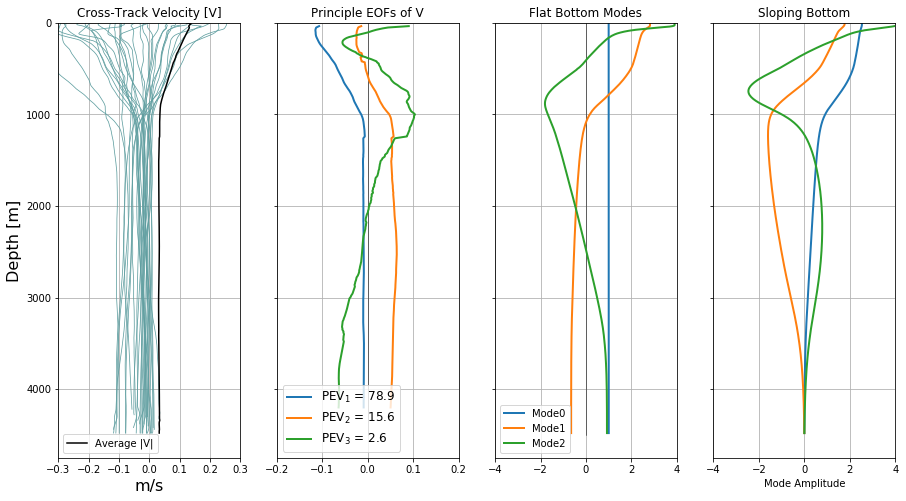

()

In [123]:
# --- plot velocity EOFs 
matplotlib.rcParams['figure.figsize'] = (15,8)
f, (ax, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
for i in range(nq):
    ax.plot(V3[:, i], grid, color='#5F9EA0', linewidth=0.75)
ax.plot(np.nanmean(np.abs(V3), axis=1), grid, color='k', label='Average |V|')
ax.set_xlim([-.3, .3])
ax.set_ylim([0, 4750])
ax.set_title('Cross-Track Velocity [V]', fontsize=12)
ax.set_xlabel('m/s', fontsize=16)
ax.set_ylabel('Depth [m]', fontsize=16)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=10)

ax2.plot(np.zeros(10), np.arange(0, 5000, 500), color='k', linewidth=0.5)
ax3.plot(np.zeros(10), np.arange(0, 5000, 500), color='k', linewidth=0.5)
colorm = 'r', 'b', 'g'
for i in range(3):
    ax2.plot(V_Uzqa[:, i], grid_check, label=r'PEV$_{' + str(i + 1) + '}$ = ' + str(100 * np.round(PEV[i], 3)),
                linewidth=2)
#     ax3.plot(V_xi_zqa[:, i], grid_check, label=r'PEV$_{' + str(i + 1) + '}$ = ' + str(100 * np.round(PEV_xi[i], 3)),
#                 linewidth=2)
    ax3.plot(Gz[:, i], grid, label='Mode' + str(i), linewidth=2)
    ax4.plot(F[:, i], grid, label='Mode' + str(i), linewidth=2)

    # if i < 1:
    #     ax4.plot(F_int[:, i] + np.nanmax(np.abs(F_int[:, i])), grid)
    # else:
    #     ax4.plot(F_int[:, i], grid)
    # ax4.plot(G[:, i], grid, c='k', linestyle='--', linewidth=0.5)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels, fontsize=12)
ax2.set_xlim([-.2, .2])
ax2.set_title('Principle EOFs of V', fontsize=12)
# ax2.set_xlabel('m/s', fontsize=16)
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles, labels, fontsize=10)
ax3.set_xlim([-4, 4])
ax3.set_title('Flat Bottom Modes', fontsize=12)
# ax3.set_xlabel('[m]', fontsize=10)
ax4.set_title('Sloping Bottom', fontsize=12)
ax4.set_xlabel('Mode Amplitude', fontsize=10)
ax4.set_xlim([-4, 4])
ax.grid()
ax2.grid()
ax3.grid()
ax.invert_yaxis()
plot_pro(ax4)

Optimization terminated successfully.
         Current function value: 0.055150
         Iterations: 25
         Function evaluations: 50
Optimization terminated successfully.
         Current function value: 0.068569
         Iterations: 8
         Function evaluations: 16
Optimization terminated successfully.
         Current function value: 0.036228
         Iterations: 32
         Function evaluations: 61
Optimization terminated successfully.
         Current function value: 0.130427
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.018867
         Iterations: 19
         Function evaluations: 38
Optimization terminated successfully.
         Current function value: 0.048468
         Iterations: 8
         Function evaluations: 16
Optimization terminated successfully.
         Current function value: 0.021596
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfull

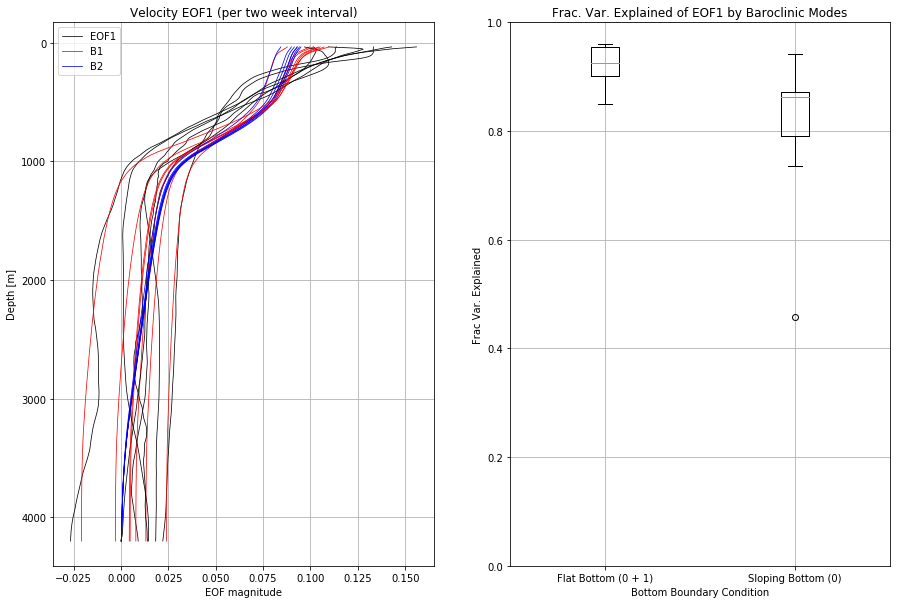

()

In [50]:
# --- EOF of velocity profiles (in two week intervals) ---
def functi_1(p, xe, xb):
    #  This is the target function that needs to be minimized
    fsq = (xe - p*xb)**2
    return fsq.sum()

def functi_2(p, xe, xb, xs):
    #  This is the target function that needs to be minimized
    fsq = (xe - (p[0] * xb + p[1] * xs)) ** 2
    # fsq = (xe - p*xb)**2
    return fsq.sum()

# loop over every two weeks (to obtain statistics)
T_week = np.arange(Time3.min(), Time3.max(), 35)
PEV_per = np.nan * np.ones((len(T_week) - 1, 10))
fvu1_per = np.nan * np.ones(len(T_week) - 1)
fvu2_per = np.nan * np.ones(len(T_week) - 1)
bc1 = Gz[check1:check2, 0]  # flat bottom (modes 0)
bc11 = + Gz[check1:check2, 1]  # flat bottom (modes 1)
bc2 = F[check1:check2, 0]  # sloping bottom  (modes 1 + 2 ... there is no barotropic mode)
f, (ax, ax1) = plt.subplots(1, 2)
AGz_eof = np.nan * np.ones((nmodes, len(T_week) - 1))
AF_eof = np.nan * np.ones((nmodes, len(T_week) - 1))
for i in range(len(T_week) - 1):
    V4 = Uzq[:, (Time3 > T_week[i]) & (Time3 < T_week[i + 1])].copy()
    nq = np.size(V4[0, :])
    avg_Uzq = np.nanmean(np.transpose(Uzq), axis=0)
    Uzqa = V4 - np.transpose(np.tile(avg_Uzq, [nq, 1]))
    cov_Uzqa = (1 / nq) * np.matrix(Uzqa) * np.matrix(np.transpose(Uzqa))
    D_Uzqa, V_Uzqa = np.linalg.eig(cov_Uzqa)
    t1 = np.real(D_Uzqa[0:10])
    # percent explained variance by each eof
    PEV_per[i, :] = (t1 / np.sum(t1))
    # percent variance explained of each eof by baroclinic modes with either bottom boundary condition
    eof1 = np.array(np.real(V_Uzqa[:, 0]))
    # -- minimize mode shapes onto eof shape
    p = np.array([0.8 * eof1.min() / np.max(np.abs(F[:, 0])), 0.8 * eof1.min() / np.max(np.abs(F[:, 0]))])
    p2 = 0.8 * eof1.min() / np.max(np.abs(F[:, 0]))
    ins1 = np.transpose(np.concatenate([eof1, bc1[:, np.newaxis], bc11[:, np.newaxis]], axis=1))
    ins2 = np.transpose(np.concatenate([eof1, bc2[:, np.newaxis]], axis=1))
    min_p1 = fmin(functi_2, p, args=(tuple(ins1)))
    min_p2 = fmin(functi_1, p2, args=(tuple(ins2)))
    fvu1_per[i] = 1 - (np.sum((eof1[:, 0] - (bc1 * min_p1[0] + bc11 * min_p1[1])) ** 2) /
                    np.sum((eof1 - np.mean(eof1)) ** 2))
    fvu2_per[i] = 1 - (np.sum((eof1[:, 0] - bc2 * min_p2) ** 2) / np.sum((eof1 - np.mean(eof1)) ** 2))

    if np.nanmean(eof1[0:20] < 0):
        if fvu1_per[i] > 0:
            ax.plot(-1 * eof1, grid_check, color='k', linewidth=0.75, label='EOF1')
            ax.plot(-1 * (bc1 * min_p1[0] + bc11 * min_p1[1]), grid_check, color='r', linewidth=0.75, label='B1')
        if fvu2_per[i] > 0:
            ax.plot(-1 * bc2 * min_p2, grid_check, color='b', linewidth=0.75, label='B2')
    else:
        if fvu1_per[i] > 0:
            ax.plot(eof1, grid_check, color='k', linewidth=0.75, label='EOF1')
            ax.plot((bc1 * min_p1[0] + bc11 * min_p1[1]), grid_check, color='r', linewidth=0.75, label='B1')
        if fvu2_per[i] > 0:
            ax.plot(bc2 * min_p2, grid_check, color='b', linewidth=0.75, label='B2')

handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[0], handles[1], handles[2]], [labels[0], labels[1], labels[2]], fontsize=10)
ax.set_title('Velocity EOF1 (per two week interval)')
ax.set_ylabel('Depth [m]')
ax.set_xlabel('EOF magnitude')
ax.invert_yaxis()

fvu1_per[fvu1_per < 0] = np.nan
fvu2_per[fvu2_per < 0] = np.nan
data1 = np.array([np.nanstd(PEV_per[:, 0]), np.nanmean(PEV_per[:, 0]), np.nanmin(PEV_per[:, 0]),
                    np.nanmax(PEV_per[:, 0])])
data2 = np.array([np.nanstd(PEV_per[:, 1]), np.nanmean(PEV_per[:, 1]), np.nanmin(PEV_per[:, 1]),
                    np.nanmax(PEV_per[:, 1])])
data3 = np.array([np.nanstd(fvu1_per), np.nanmean(fvu1_per), np.nanmin(fvu1_per), np.nanmax(fvu1_per)])
data4 = np.array([np.nanstd(fvu2_per), np.nanmean(fvu2_per), np.nanmin(fvu2_per), np.nanmax(fvu2_per)])

# ax1.boxplot([data1, data2])
# np.concatenate((fvu1_per[:, None], fvu2_per[:, None]), axis=1)
ax1.boxplot([fvu1_per[:, None], fvu2_per[~np.isnan(fvu2_per)]])
ax1.set_ylim([0, 1])
ax1.set_title('Frac. Var. Explained of EOF1 by Baroclinic Modes')
ax1.set_xlabel('Bottom Boundary Condition')
ax1.set_ylabel('Frac Var. Explained')
ax1.set_xticklabels(['Flat Bottom (0 + 1)', 'Sloping Bottom (0)'])
# ax2.set_title('Bottom Boundary Condition')
# ax2.set_ylabel('Frac Var. Explained by Mode Shapes')
# ax2.set_ylim([0, 1])
ax.grid()
plot_pro(ax1)

The figure above addresses the de La Lama conclusion and compares which structure captures more of the variance of the horizontal velocity profiles (structure 1 = BT + BC1 (flat bottom), structure 2 = BC1 (sloping bottom) 

In [49]:
# --- Isolate eddy dives ---
# 2015 - dives 62, 63 ,64
ed_prof_in = np.where(((x.dives) >= 62) & ((x.dives) <= 66))[0]
ed_in = np.where((Info2 >= 62) & (Info2 <= 70))[0]
ed_in_2 = np.where((Info2 > 61) & (Info2 < 63))[0]
ed_time_s = datetime.date.fromordinal(np.int(Time2[ed_in[0]]))
ed_time_e = datetime.date.fromordinal(np.int(Time2[ed_in[-1] + 1]))
# --- time series
mission_start = datetime.date.fromordinal(np.int(Time2.min()))
mission_end = datetime.date.fromordinal(np.int(Time2.max()))

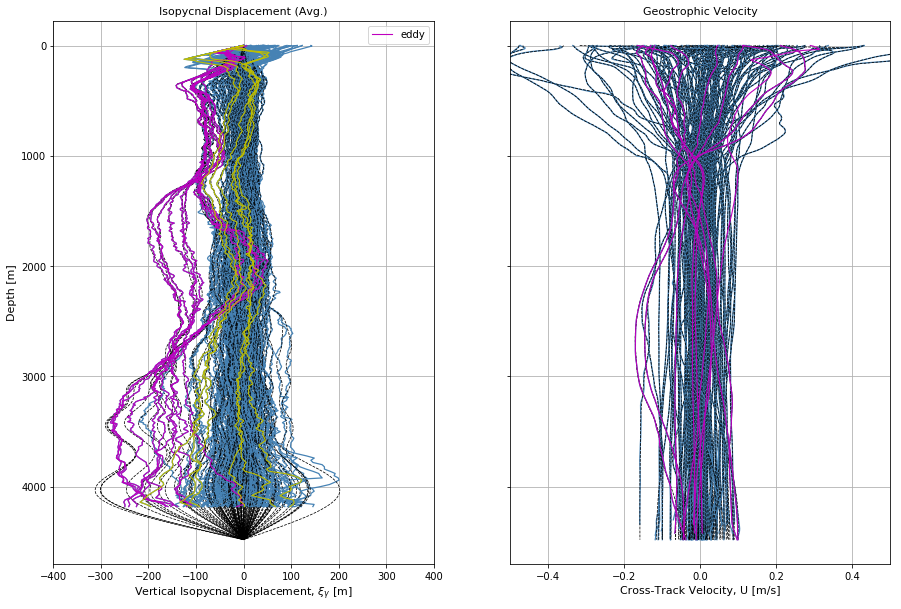

()

In [51]:
# plot eta 
plt.rcParams['figure.figsize'] = 15, 10
f_eta, (ax1, ax0) = plt.subplots(1, 2, sharey=True)
pzmax = -15
for j in range(num_profs):
    ax1.plot(Eta2[0:pzmax, j], grid[0:pzmax], color='#4682B4', linewidth=1.25)
    ax1.plot(Eta_m[:, j], grid, color='k', linestyle='--', linewidth=.75)
    if good_ke_prof[j] > 0:
        ax0.plot(V2[:, j], grid, color='#4682B4', linewidth=1.25)
        ax0.plot(V_m[:, j], grid, color='k', linestyle='--', linewidth=.75)

for k in range(len(ed_in)):
    ax1.plot(Eta2[0:pzmax, ed_in[k]], grid[0:pzmax], color='m', linewidth=1.1, label='eddy')
    ax0.plot(V2[:, ed_in[k]], grid, color='m', linewidth=1.1)
# before eddy
pre_ed = np.where((Info2 >= 55) & (Info2 <= 62))[0]
for k in range(len(pre_ed)):
    ax1.plot(Eta2[0:pzmax, pre_ed[k]], grid[0:pzmax], color='y', linewidth=1.1, label='eddy')
handles, labels = ax1.get_legend_handles_labels()
ax1.legend([handles[0]], [labels[0]], fontsize=10)        
# ax0.text(150, 4500, str(num_profs) + ' Profiles')
ax1.set_xlim([-400, 400])        
ax1.invert_yaxis()
ax1.grid()
ax0.set_xlim([-.5, .5])
ax0.set_title("Geostrophic Velocity", fontsize=11)  # (" + str(num_profs) + 'profiles)' )
ax0.set_xlabel('Cross-Track Velocity, U [m/s]', fontsize=11)
ax1.set_xlabel(r'Vertical Isopycnal Displacement, $\xi_{\gamma}$ [m]', fontsize=11)
ax1.set_title(r'Isopycnal Displacement (Avg.)', fontsize=11)
ax1.set_ylabel('Depth [m]', fontsize=11)
plot_pro(ax0)    


In [102]:
# find velocity profiles with speeds in the upper few hundred meters (and eddy profiles)
# look at bottom t/s to see if there is stirring 
print(np.where(np.abs(V2[40, :]) > 0.25)[0])
strong_profs = Info2[np.where(np.abs(V2[40, :]) > 0.25)[0]]
print(strong_profs)

[ 14  15  46  47  49  50  51  52  67  87 102 122 126]
[  73.    73.5   80.5   81.    82.    82.5   83.    83.5  133.    63.5
   22.5  105.   107. ]


In [218]:
# finely grid a few dives to look at profiles at the bottom 
grid_special = np.arange(0, 4800, 1)
xss = Glider(35, np.array([55, 57, 62, 63, 64, 82, 83]), '/Users/jake/Documents/baroclinic_modes/DG/BATS_2015/sg035')
outt = xss.make_bin(grid_special)
sa_s, ct_s, theta_s, sig0_s, sig2_s, dg_N2_s = xss.density(grid_special, ref_lat, outt['temp'][:], outt['sal'][:], 
                                               outt['lon'][:], outt['lat'][:])


/Users/jake/Documents/geostrophic_turbulence/glider_cross_section.py:104: RuntimeWarning: invalid value encountered in greater
  sal_d.append(gd['salinity'][0:pitch_d])
/Users/jake/Documents/geostrophic_turbulence/glider_cross_section.py:105: RuntimeWarning: invalid value encountered in greater
  sal_d.append(gd['salinity'][pitch_c:])
/Users/jake/Documents/geostrophic_turbulence/glider_cross_section.py:158: RuntimeWarning: Mean of empty slice
  temp_g[0, k] = np.nanmean(temp[dp_in_d_1])
/Users/jake/Documents/geostrophic_turbulence/glider_cross_section.py:159: RuntimeWarning: Mean of empty slice
  sal_g[0, k] = np.nanmean(sal[dp_in_d_1])
/Users/jake/Documents/geostrophic_turbulence/glider_cross_section.py:160: RuntimeWarning: Mean of empty slice
  lon_g[0, k] = np.nanmean(lon[dp_in_d_1])
/Users/jake/Documents/geostrophic_turbulence/glider_cross_section.py:161: RuntimeWarning: Mean of empty slice
  lat_g[0, k] = np.nanmean(lat[dp_in_d_1])
/Users/jake/Documents/geostrophic_turbulence/glid

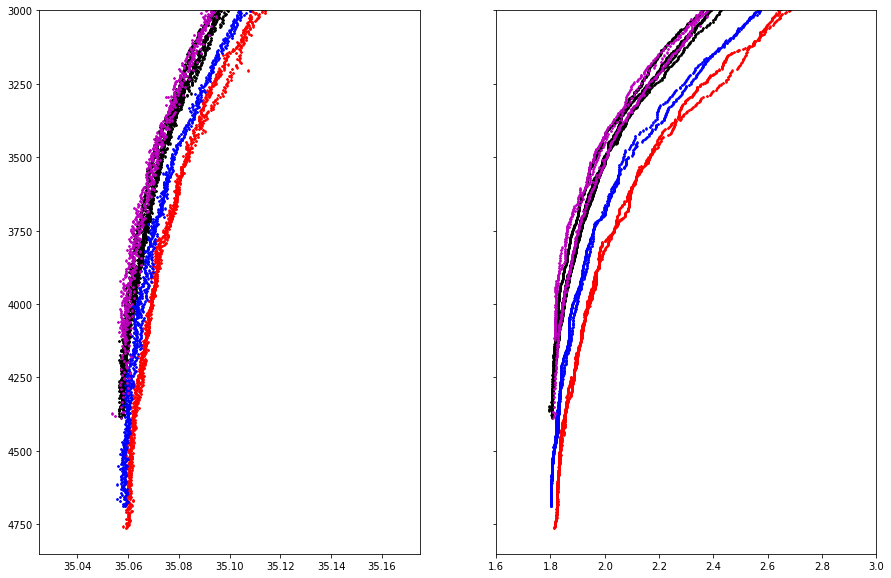

()

In [220]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.scatter(sa_s[:, 0], grid_special, 2, color='k')
ax2.scatter(ct_s[:, 0], grid_special, 2, color='k')
ax1.scatter(sa_s[:, 1], grid_special, 2, color='k')
ax2.scatter(ct_s[:, 1], grid_special, 2, color='k')
ax1.scatter(sa_s[:, 2], grid_special, 2, color='k')
ax2.scatter(ct_s[:, 2], grid_special, 2, color='k')
ax1.scatter(sa_s[:, 3], grid_special, 2, color='k')
ax2.scatter(ct_s[:, 3], grid_special, 2, color='k')

ax1.scatter(sa_s[:, 6], grid_special, 2, color='r')
ax2.scatter(ct_s[:, 6], grid_special, 2, color='r')
ax1.scatter(sa_s[:, 7], grid_special, 2, color='r')
ax2.scatter(ct_s[:, 7], grid_special, 2, color='r')
ax1.scatter(sa_s[:, 8], grid_special, 2, color='b')
ax2.scatter(ct_s[:, 8], grid_special, 2, color='b')
ax1.scatter(sa_s[:, 9], grid_special, 2, color='b')
ax2.scatter(ct_s[:, 9], grid_special, 2, color='b')

ax1.scatter(sa_s[:, -4], grid_special, 2, color='m')
ax2.scatter(ct_s[:, -4], grid_special, 2, color='m')
ax1.scatter(sa_s[:, -3], grid_special, 2, color='m')
ax2.scatter(ct_s[:, -3], grid_special, 2, color='m')
ax1.scatter(sa_s[:, -2], grid_special, 2, color='m')
ax2.scatter(ct_s[:, -2], grid_special, 2, color='m')
ax1.scatter(sa_s[:, -1], grid_special, 2, color='m')
ax2.scatter(ct_s[:, -1], grid_special, 2, color='m')

ax1.set_xlim([35.025, 35.175])
ax2.set_xlim([1.6, 3])
ax2.set_ylim([3000, 4850])
ax2.invert_yaxis()
plot_pro(ax)    

# see a marked shift as this eddy comes by (dives 59 to roughly 80)

In [110]:
dg62_f['ctd_depth'][:]

array([ 1.00275743,  1.20119896,  1.22060995, ...,  2.49764474,
        1.80609903,  1.2008659 ])

In [78]:
len(grid_special)

1100

In [70]:
len(profile_tags)

328

In [206]:
np.shape(sa_s)

(4800, 12)

In [ ]:
dg55_f = '/Users/jake/Documents/baroclinic_modes/DG/BATS_2015/sg035/p0350055.nc'
dg55 = Dataset(dg55_f, 'r')
temp55 = dg55['temperature'][:]
sal55 = dg55['salinity'][:]
dep55 = dg55['ctd_depth'][:]

dg57_f = '/Users/jake/Documents/baroclinic_modes/DG/BATS_2015/sg035/p0350057.nc'
dg57 = Dataset(dg57_f, 'r')
temp57 = dg57['temperature'][:]
sal57 = dg57['salinity'][:]
dep57 = dg57['ctd_depth'][:]

dg62_f = '/Users/jake/Documents/baroclinic_modes/DG/BATS_2015/sg035/p0350062.nc'
dg62 = Dataset(dg62_f, 'r')
temp62 = dg62['temperature'][:]
sal62 = dg62['salinity'][:]
dep62 = dg62['ctd_depth'][:]

dg63_f = '/Users/jake/Documents/baroclinic_modes/DG/BATS_2015/sg035/p0350063.nc'
dg63 = Dataset(dg63_f, 'r')
temp63 = dg63['temperature'][:]
sal63 = dg63['salinity'][:]
dep63 = dg63['ctd_depth'][:]

dg64_f = '/Users/jake/Documents/baroclinic_modes/DG/BATS_2015/sg035/p0350064.nc'
dg64 = Dataset(dg64_f, 'r')
temp64 = dg64['temperature'][:]
sal64 = dg64['salinity'][:]
dep64 = dg64['ctd_depth'][:]

dg68_f = '/Users/jake/Documents/baroclinic_modes/DG/BATS_2015/sg035/p0350083.nc'
dg68 = Dataset(dg68_f, 'r')
temp68 = dg68['temperature'][:]
sal68 = dg68['salinity'][:]
dep68 = dg68['ctd_depth'][:]

ax1.scatter(sal55, dep55, 2, color='k')
ax2.scatter(temp55, dep55, 2, color='k')
ax1.scatter(sal57, dep57, 2, color='k')
ax2.scatter(temp57, dep57, 2, color='k')

ax1.scatter(sal62, dep62, 2)
ax2.scatter(temp62, dep62, 2)

ax1.scatter(sal63, dep63, 2, color='r')
ax2.scatter(temp63, dep63, 2, color='r')

ax1.scatter(sal64, dep64, 2)
ax2.scatter(temp64, dep64, 2)

ax1.scatter(sal68, dep68, 2, color='b')
ax2.scatter(temp68, dep68, 2, color='b')